In [25]:
import instruments as inst
import copy
import numpy as np

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [26]:
file_path = "20230914_processed_table.csv"
wavelength_string = 670
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[ 19443.    27359.5  -26523.5   29186.    10360.5   27538.5  -17840.5
  28326.   -10662.5   28418.5    3473.    27876.   -27267.5   29836.5
  21314.    27976.5  -27920.5   29951.5   23421.5   28214.   -12034.
  28774.     8556.    28492.5   10305.5   27996.5  -13423.    29077.
  21867.    27914.   -25387.5   29809.5   14391.5   28174.   -20535.5
  29352.5   20802.5   27697.   -27617.    29505.     9551.    28000.5
 -17167.5   28696.   -12391.5   28871.5    4892.5   28166.   -28211.
  30113.5   21892.5   28098.5  -27316.    29949.    22458.    28215.
 -10273.    28577.5    6538.5   28392.    11477.    27759.   -14727.5
  28943.     -867.5   29043.    -3647.    29198.    18165.5   28361.5
 -23641.    29681.5   22278.    28083.   -28827.    29929.     8984.
  28448.   -16566.    29038.   -13928.    29321.5    6282.    28442.5
 -28623.5   30393.    22020.    28267.5  -26182.    30032.    20955.
  28281.    -8140.    28472.     3993.5   28344.5  -16823.    29

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [27]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

theta_pol = past_fit[0]
delta_HWP = past_fit[1]
offset_HWP = past_fit[2]
delta_derot = past_fit[3]
offset_derot = past_fit[4]
delta_opts = past_fit[5]
epsilon_opts = past_fit[6]
rot_opts = past_fit[7]
delta_FLC = past_fit[8]
rot_FLC = past_fit[9]
em_gain = past_fit[10]

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "general_retarder_function",
            "properties": {"phi": 0, "theta": 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": offset_derot},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
        # Testing whether generate_system_mueller_matrix can flag this as a non-existent component
        "test_false_type": {
            "type": "test",
            "properties": {"theta": 0, "epsilon": 0}
        },
        # Testing whether generate_system_mueller_matrix can flag epsilon as a
        # non-existent property of rotator
        "test_false_property": {
            "type": "general_retarder_function",
            "properties": {"epsilon": 0}
        }
    }
}

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [28]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

Error: 'test' is not a valid function in pyMuellerMat.common_mm_functions and will be skipped.
[[0.51859792 0.51785552 0.02773924 0.        ]
 [0.51859792 0.51785552 0.02773924 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# TEST: Checking parse_configuration & update_system_mm

In [29]:
test_configuration = {
    'lp': {'theta': 0.0},
    'hwp': {'theta': 0.0},
    'image_rotator': {'theta': 0.0},
    'flc': {'theta': 0.0},
    'wollaston': {'beam': 'o'}
    }

values, keywords = inst.parse_configuration(test_configuration)
print("Values: " + str(values))
print("Keywords: " + str(keywords))

updated_system_mm = inst.update_system_mm(values, keywords, system_mm)
# print(updated_system_mm.evaluate())


Values: [0.0, 0.0, 0.0, 0.0, 'o']
Keywords: [['lp', 'theta'], ['hwp', 'theta'], ['image_rotator', 'theta'], ['flc', 'theta'], ['wollaston', 'beam']]


# Step 4: Creating a dictionary of p0 starting guesses

In [30]:
# Fittin for just the dichroic for now

p0 = {
    "dichroic": {"phi": 0, "theta": 0}
}

p0_values, p0_keywords = inst.parse_configuration(p0)

# Step 5: Running minimize_system_Mueller_matrix

In [31]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])

result = inst.minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
    interleaved_stds, configuration_list, s_in = s_in,
    process_dataset = inst.process_dataset, process_errors = inst.process_errors, 
    process_model = inst.process_model)
print(result.x)

p0_values:  [0, 0]
p0_keywords:  [['dichroic', 'phi'], ['dichroic', 'theta']]
Differences:  [ 19443.  -26523.5  10360.5 -17840.5 -10662.5   3473.  -27267.5  21314.
 -27920.5  23421.5 -12034.    8556.   10305.5 -13423.   21867.  -25387.5
  14391.5 -20535.5  20802.5 -27617.    9551.  -17167.5 -12391.5   4892.5
 -28211.   21892.5 -27316.   22458.  -10273.    6538.5  11477.  -14727.5
   -867.5  -3647.   18165.5 -23641.   22278.  -28827.    8984.  -16566.
 -13928.    6282.  -28623.5  22020.  -26182.   20955.   -8140.    3993.5
 -16823.   13560.5   3715.   -7432.5  21281.  -26048.   23101.5 -29247.
   7677.  -15068.  -15426.    7786.5 -28998.   22177.  -25029.5  19219.
 -23479.   20439.5 -13912.   11204.5   6905.  -10089.   22826.  -27014.
  22588.5 -28287.5   5631.  -12706.5 -17581.   10089.  -29446.   22534.
 -17513.   13575.  -23688.   20664.5 -12786.   10271.    8128.  -10961.
  22929.  -26679.5  20961.  -26189.    2553.   -9241.5 -20015.5  12819.5
  -1948.   -3620.5 -20633.   16164.5 -2

 [ 19443.  -26523.5  10360.5 -17840.5 -10662.5   3473.  -27267.5  21314.
 -27920.5  23421.5 -12034.    8556.   10305.5 -13423.   21867.  -25387.5
  14391.5 -20535.5  20802.5 -27617.    9551.  -17167.5 -12391.5   4892.5
 -28211.   21892.5 -27316.   22458.  -10273.    6538.5  11477.  -14727.5
   -867.5  -3647.   18165.5 -23641.   22278.  -28827.    8984.  -16566.
 -13928.    6282.  -28623.5  22020.  -26182.   20955.   -8140.    3993.5
 -16823.   13560.5   3715.   -7432.5  21281.  -26048.   23101.5 -29247.
   7677.  -15068.  -15426.    7786.5 -28998.   22177.  -25029.5  19219.
 -23479.   20439.5 -13912.   11204.5   6905.  -10089.   22826.  -27014.
  22588.5 -28287.5   5631.  -12706.5 -17581.   10089.  -29446.   22534.
 -17513.   13575.  -23688.   20664.5 -12786.   10271.    8128.  -10961.
  22929.  -26679.5  20961.  -26189.    2553.   -9241.5 -20015.5  12819.5
  -1948.   -3620.5 -20633.   16164.5 -25326.   22022.  -13084.5  10481.
   8453.  -11124.5  22145.  -25672.5  18649.5 -23619.5   -

# Step 6: Plot model with best fit

[  3.15725423 -74.47601114]
[['dichroic', 'phi'], ['dichroic', 'theta']]
Model Length:  160
Configurations List Length:  160
Differences:  [ 19443.  -26523.5  10360.5 -17840.5 -10662.5   3473.  -27267.5  21314.
 -27920.5  23421.5 -12034.    8556.   10305.5 -13423.   21867.  -25387.5
  14391.5 -20535.5  20802.5 -27617.    9551.  -17167.5 -12391.5   4892.5
 -28211.   21892.5 -27316.   22458.  -10273.    6538.5  11477.  -14727.5
   -867.5  -3647.   18165.5 -23641.   22278.  -28827.    8984.  -16566.
 -13928.    6282.  -28623.5  22020.  -26182.   20955.   -8140.    3993.5
 -16823.   13560.5   3715.   -7432.5  21281.  -26048.   23101.5 -29247.
   7677.  -15068.  -15426.    7786.5 -28998.   22177.  -25029.5  19219.
 -23479.   20439.5 -13912.   11204.5   6905.  -10089.   22826.  -27014.
  22588.5 -28287.5   5631.  -12706.5 -17581.   10089.  -29446.   22534.
 -17513.   13575.  -23688.   20664.5 -12786.   10271.    8128.  -10961.
  22929.  -26679.5  20961.  -26189.    2553.   -9241.5 -20015.5  

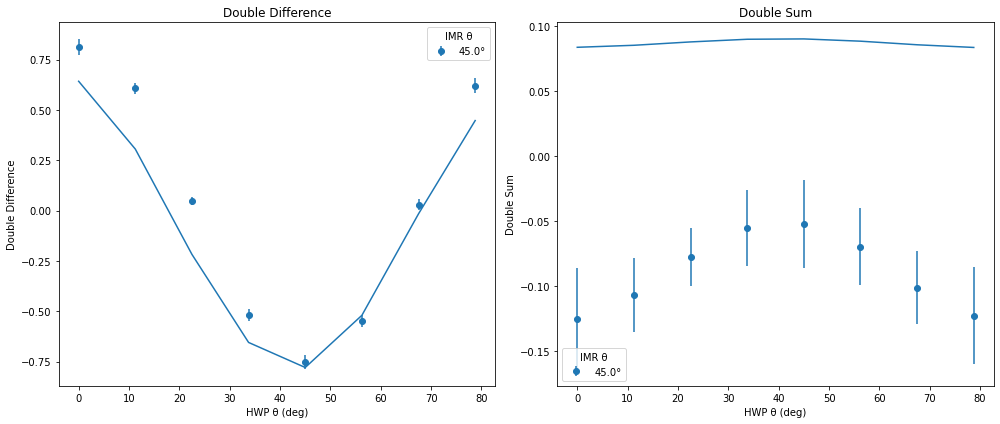

In [32]:
# Generate model with p0 keywords but scipy minimized results
print(result.x)
print(p0_keywords)

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)
print("Model Length: ", len(model))
print("Configurations List Length: ", len(configuration_list))

# print(interleaved_values)

inst.plot_data(interleaved_values, interleaved_stds, model, configuration_list, imr_theta_filter = 45)